Pipeline for illumination correction of images for high-throughput microscopy. Singh et al., 2014

In [85]:
# find all tif files in the directory
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from skimage import io
from skimage.morphology import disk
from skimage.filters import median
from scipy.ndimage import median_filter
from scipy.signal import medfilt2d
import seaborn as sns
import pandas as pd
from pathlib import Path

In [86]:
tif_dir = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/tifs_3channel"
channel_idx = 0
diam = 51

idx_to_name = {0: "Actin", 1: "RNA", 2: "DNA"}
tif_files = glob.glob(os.path.join(tif_dir, "*.tif"))
tif_files = [Path(f) for f in tif_files]

In [87]:
tif_dir2 = "/Users/thomasathey/Documents/shavit-lab/fraenkel/papers/cvpr/data/all/tifs_3channel_remove"

tif_files2 = glob.glob(os.path.join(tif_dir2, "*.tif"))
tif_files2 = [Path(f) for f in tif_files2]
tif_files2_stems = [f.stem for f in tif_files2]

for tif_file in tif_files:
    if tif_file.stem not in tif_files2_stems:
        print(tif_file.stem)

e1_wD5_f1
e1_wD5_f2
e1_wB11_f1
e1_wC6_f1
e1_wC9_f1
e1_wE6_f1
e1_wB9_f1


# Illumination Field

In [88]:
def compute_icf(tif_files, channel_idx, diam):
    sum = np.zeros_like(io.imread(tif_files[0])[:,:,channel_idx])
    for tif_file in tif_files:
        img = io.imread(tif_file)
        im = img[:, :, channel_idx]
        sum += im
    icf = sum / len(tif_files)
    icf_smooth = median_filter(icf, size=diam)

    return icf, icf_smooth

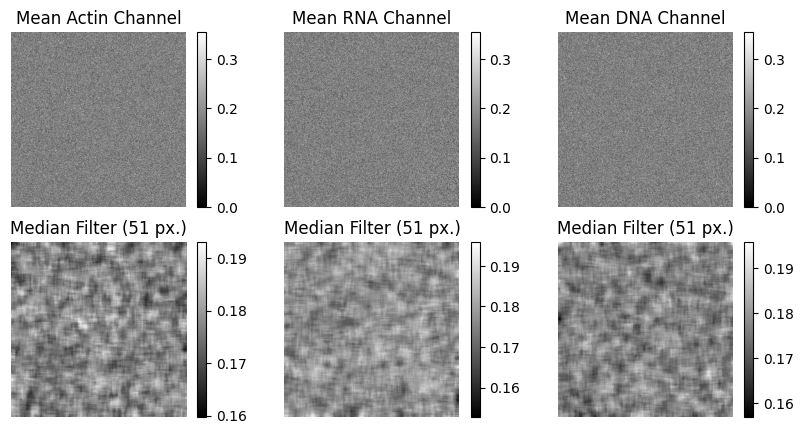

In [89]:
# make two subplots
f, ax = plt.subplots(2, 3, figsize=(10, 5))

for channel_idx, ax_col in zip([0,1,2], ax.T):
    icf, icf_smooth = compute_icf(tif_files, channel_idx, diam)

    implot = ax_col[0].imshow(icf, cmap='gray')
    # turn off axis labels
    ax_col[0].axis('off')
    ax_col[0].set_title(f"Mean {idx_to_name[channel_idx]} Channel")
    f.colorbar(implot, ax=ax_col[0])

    implot = ax_col[1].imshow(icf_smooth, cmap='gray')
    # turn off axis labels
    ax_col[1].axis('off')
    ax_col[1].set_title(f"Median Filter ({diam} px.)")
    # add colorbar to ax[1]
    f.colorbar(implot, ax=ax_col[1])

# Intensity Between Groups

In [69]:
from scipy.stats import kstest
from cell_paint_seg.experiment_layouts import id_from_name_dataset, line_from_id, condition_from_id

<Axes: xlabel='Type', ylabel='Intensity'>

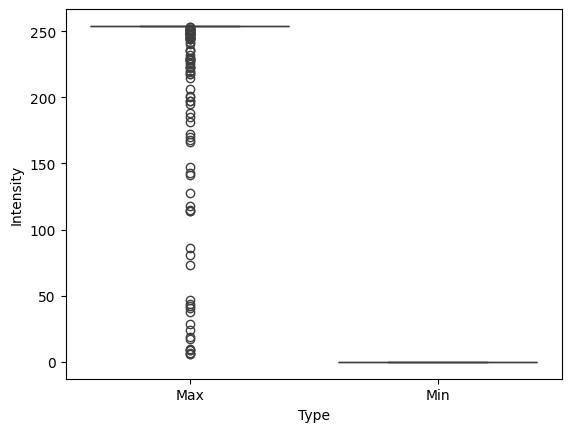

In [75]:
data_intensity = []
data_type = []

counter = 0

for tif_file in tif_files:
    img = io.imread(tif_file)
    max_intensity = np.amax(img[:, :, channel_idx])
    data_intensity.append(max_intensity)
    data_type.append("Max")
    min_intensity = np.amin(img[:, :, channel_idx])
    data_intensity.append(min_intensity)
    data_type.append("Min")


df = pd.DataFrame({"Intensity": data_intensity, "Type": data_type})
sns.boxplot(x="Type", y="Intensity", data=df)

In [76]:
df[df["Type"] == "Min"].describe()

,Intensity
count,720.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


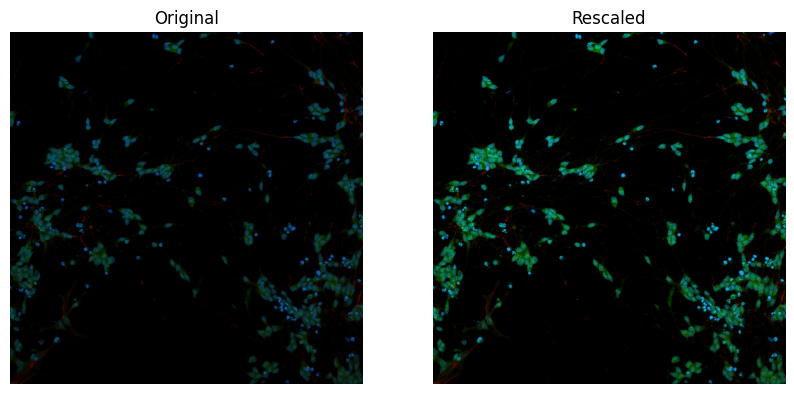

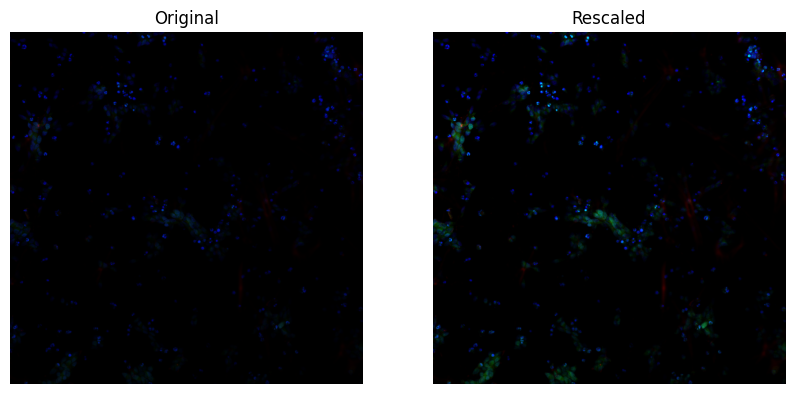

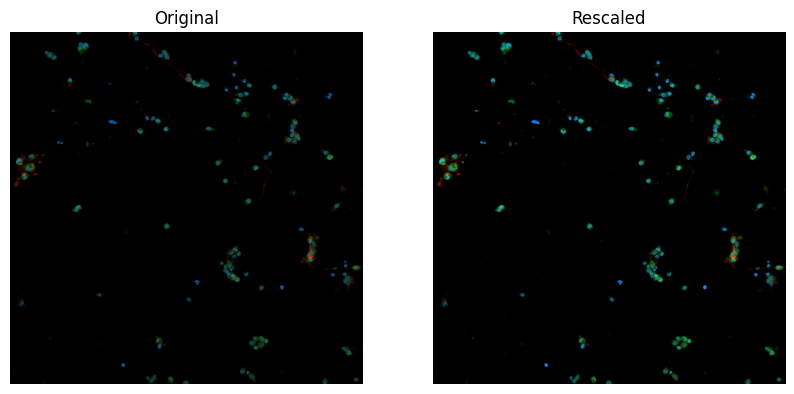

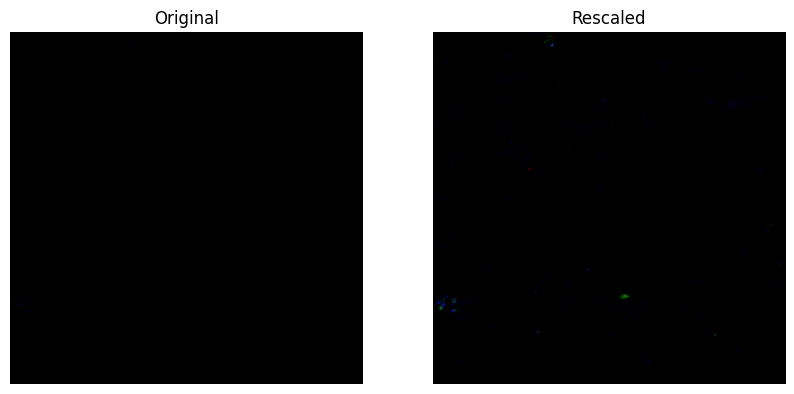

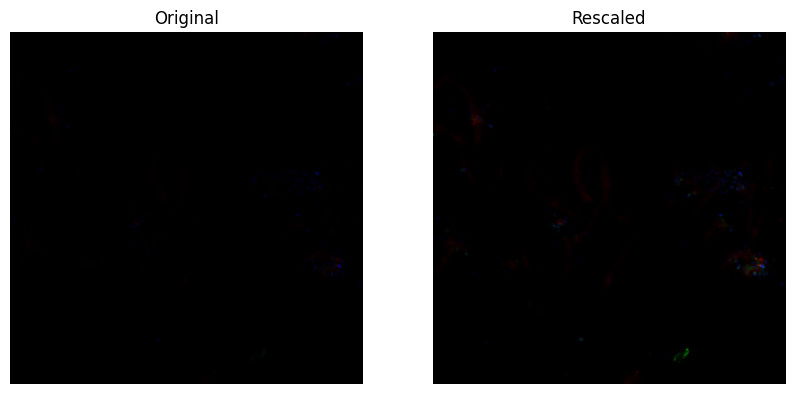

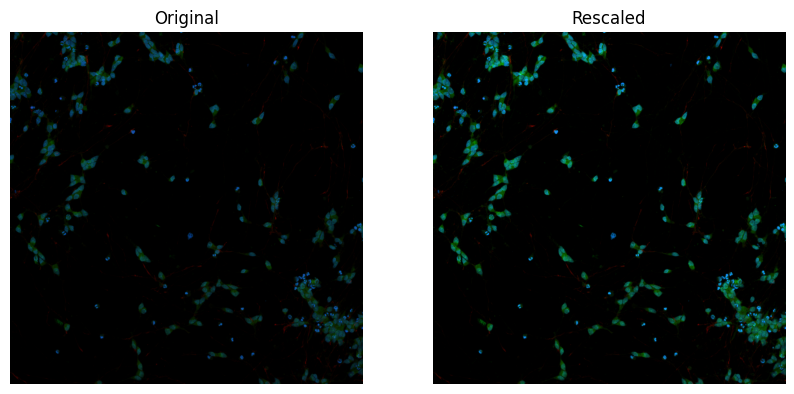

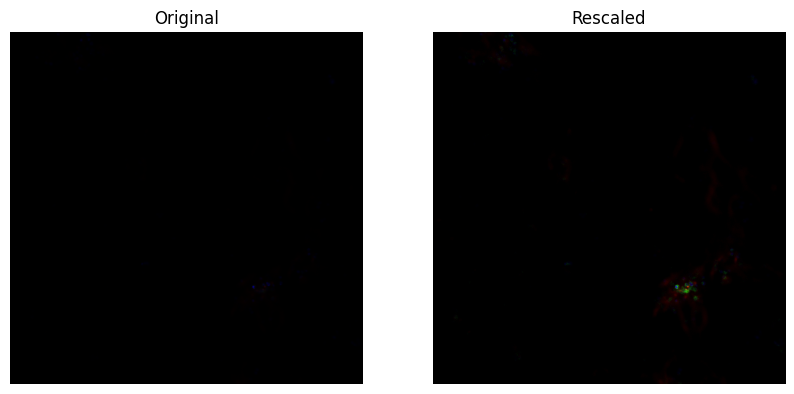

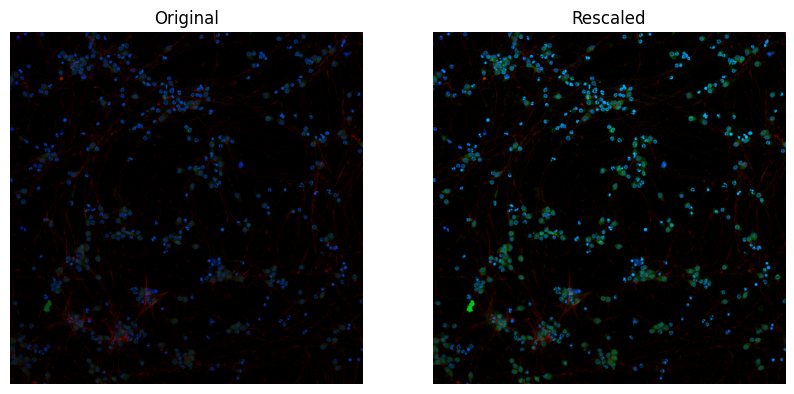

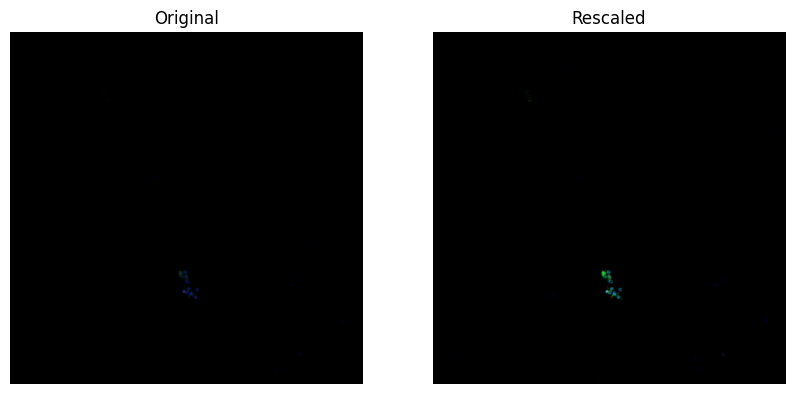

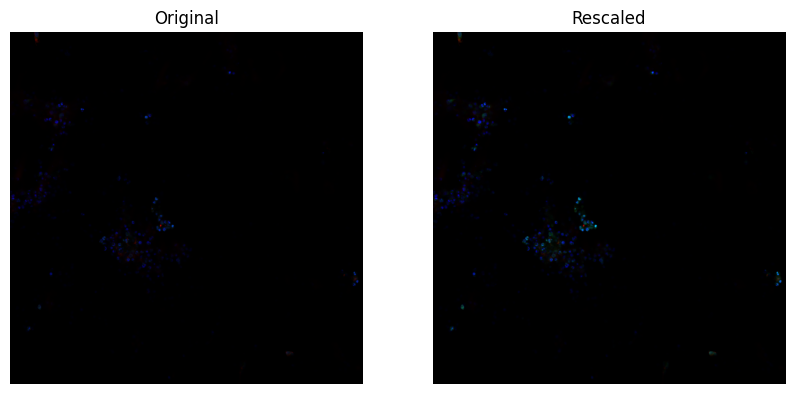

In [79]:
counter = 0

for tif_file in tif_files:
    img = io.imread(tif_file).astype(float) / 255

    max_intensity = np.amax(img[:, :, channel_idx])
    min_intensity = np.amin(img[:, :, channel_idx])

    img_rescaled = np.zeros_like(img)
    for c in range(3):
        img_rescaled[:,:,c] = img[:,:,c] / np.amax(img[:,:,c])


    if max_intensity < 254/255 and counter < 10:
        f, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Original")
        ax[0].axis('off')
        ax[1].imshow(img_rescaled)
        ax[1].set_title("Rescaled")
        ax[1].axis('off')
        plt.show()
        
        counter += 1